# DATA PREPROCESSING

In [8]:
# Simple K2 Dataset Preprocessing for Model Training
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

print("=" * 50)
print("K2 DATASET PREPROCESSING")
print("=" * 50)

# Load K2 dataset
k2_data = pd.read_csv("Datasets/K2.csv", skiprows=118)
print(f"Initial K2 dataset: {k2_data.shape}")

# Check if target column exists
if "disposition" in k2_data.columns:
    print("✓ Target column 'disposition' found")

    # Show target distribution
    print("Disposition value counts:")
    print(k2_data["disposition"].value_counts())

    # Create target column: CANDIDATE & CONFIRMED → 1, FALSE POSITIVE → 0
    k2_data["target"] = k2_data["disposition"].map(
        {"CANDIDATE": 1, "CONFIRMED": 1, "FALSE POSITIVE": 0}
    )

    # Remove rows with missing targets
    k2_data = k2_data.dropna(subset=["target"])
    print(f"After removing missing targets: {k2_data.shape}")

    # Remove row id
    k2_data = k2_data.drop(columns=["loc_rowid"], errors="ignore")
    
    # Verify target encoding
    print("\nTarget distribution:")
    target_counts = k2_data["target"].value_counts()
    print(f"  False Positive (0): {target_counts.get(0, 0)}")
    print(f"  Exoplanet (1): {target_counts.get(1, 0)}")

    # Select only numeric features + target
    numeric_cols = k2_data.select_dtypes(include=[np.number]).columns.tolist()
    if "target" not in numeric_cols:
        numeric_cols.append("target")

    k2_clean = k2_data[numeric_cols].copy()
    print(f"Selected numeric features: {len(numeric_cols) - 1}")  # -1 for target

    # Handle missing values in features (exclude target)
    feature_cols = [col for col in numeric_cols if col != "target"]
    missing_count = k2_clean[feature_cols].isnull().sum().sum()
    print(f"Missing values in features: {missing_count}")

    if missing_count > 0:
        # Impute missing values with median using a safer approach
        imputer = SimpleImputer(strategy="median")

        # Debug: Check which columns can actually be imputed
        print(
            f"  Debug: Checking {len(feature_cols)} feature columns for imputation..."
        )

        # Filter columns that can be safely imputed
        valid_feature_cols = []
        for col in feature_cols:
            try:
                # Test if column can be processed by imputer
                test_data = k2_clean[[col]].copy()
                test_imputer = SimpleImputer(strategy="median")
                test_imputer.fit_transform(test_data)
                valid_feature_cols.append(col)
            except Exception as e:
                print(f"    Skipping column '{col}': {e}")

        print(f"  Valid columns for imputation: {len(valid_feature_cols)}")

        if len(valid_feature_cols) > 0:
            # Perform imputation only on valid columns
            imputed_data = imputer.fit_transform(k2_clean[valid_feature_cols])

            # Debug: Check shapes before assignment
            print(f"  Imputed data shape: {imputed_data.shape}")
            print(f"  Valid columns count: {len(valid_feature_cols)}")

            # Ensure shapes match before assignment
            if imputed_data.shape[1] == len(valid_feature_cols):
                # Create DataFrame from imputed data for safe assignment
                imputed_df = pd.DataFrame(
                    imputed_data, columns=valid_feature_cols, index=k2_clean.index
                )

                # Update only the valid columns
                for col in valid_feature_cols:
                    k2_clean[col] = imputed_df[col]

                print(
                    f"  Missing values after imputation: {k2_clean[valid_feature_cols].isnull().sum().sum()}"
                )

                # Update feature_cols to only include successfully imputed columns
                feature_cols = valid_feature_cols
            else:
                print(
                    f"  ⚠️ Shape mismatch: imputed_data has {imputed_data.shape[1]} columns, expected {len(valid_feature_cols)}"
                )
                print("  Skipping imputation due to shape mismatch")
        else:
            print("  No valid columns found for imputation")
    else:
        print("No missing values found in features")

    print("\nFinal preprocessed K2 dataset:")
    print(f"  Shape: {k2_clean.shape}")
    print(f"  Features: {len(feature_cols)}")
    print(f"  Target distribution: {dict(k2_clean['target'].value_counts())}")

    # Save as k2_processed for model training
    k2_processed = k2_clean
    print("\n✅ K2 preprocessing complete! Dataset ready for training.")

else:
    print("❌ Target column 'disposition' not found!")
    print(f"Available columns: {k2_data.columns.tolist()[:10]}...")

K2 DATASET PREPROCESSING
Initial K2 dataset: (4004, 113)
✓ Target column 'disposition' found
Disposition value counts:
disposition
CONFIRMED         2315
CANDIDATE         1374
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64
After removing missing targets: (3982, 114)

Target distribution:
  False Positive (0): 293
  Exoplanet (1): 3689
Selected numeric features: 92
Missing values in features: 127749
  Debug: Checking 92 feature columns for imputation...
  Valid columns for imputation: 92
  Imputed data shape: (3982, 91)
  Valid columns count: 92
  ⚠️ Shape mismatch: imputed_data has 91 columns, expected 92
  Skipping imputation due to shape mismatch

Final preprocessed K2 dataset:
  Shape: (3982, 93)
  Features: 92
  Target distribution: {1.0: np.int64(3689), 0.0: np.int64(293)}

✅ K2 preprocessing complete! Dataset ready for training.


In [9]:
# Remove NaN columns from k2_processed
print("=" * 50)
print("REMOVING NAN COLUMNS FROM K2 DATASET")
print("=" * 50)

if "k2_processed" in locals() and k2_processed is not None:
    print(f"Original k2_processed shape: {k2_processed.shape}")

    # Check for columns with all NaN values
    nan_columns = k2_processed.columns[k2_processed.isnull().all()].tolist()
    print(f"Columns with all NaN values: {len(nan_columns)}")

    if nan_columns:
        print(f"NaN columns to remove: {nan_columns[:10]}...")  # Show first 10

        # Remove columns with all NaN values
        k2_processed = k2_processed.drop(columns=nan_columns)
        print(f"After removing NaN columns: {k2_processed.shape}")
    else:
        print("No columns with all NaN values found")

    # Also check for columns with very high percentage of NaN values (optional)
    threshold = 0.95  # Remove columns with >95% NaN values
    high_nan_columns = []

    for col in k2_processed.columns:
        if col != "target":  # Don't check target column
            nan_percentage = k2_processed[col].isnull().sum() / len(k2_processed)
            if nan_percentage > threshold:
                high_nan_columns.append(col)

    if high_nan_columns:
        print(f"\nColumns with >{threshold * 100}% NaN values: {len(high_nan_columns)}")
        print(f"High NaN columns: {high_nan_columns[:5]}...")  # Show first 5

        # Remove high NaN columns
        k2_processed = k2_processed.drop(columns=high_nan_columns)
        print(f"After removing high NaN columns: {k2_processed.shape}")
    else:
        print(f"No columns with >{threshold * 100}% NaN values found")

    # Final summary
    print("\nFinal k2_processed dataset:")
    print(f"  Shape: {k2_processed.shape}")
    print(f"  Total missing values: {k2_processed.isnull().sum().sum()}")
    print(f"  Target distribution: {dict(k2_processed['target'].value_counts())}")

    # Update feature columns list
    feature_cols = [col for col in k2_processed.columns if col != "target"]
    print(f"  Features after NaN removal: {len(feature_cols)}")

    print("\n✅ NaN columns removed successfully!")

else:
    print("❌ k2_processed not found! Please run preprocessing first.")

REMOVING NAN COLUMNS FROM K2 DATASET
Original k2_processed shape: (3982, 93)
Columns with all NaN values: 1
NaN columns to remove: ['sy_icmag']...
After removing NaN columns: (3982, 92)

Columns with >95.0% NaN values: 10
High NaN columns: ['pl_msinie', 'pl_msinij', 'pl_cmasse', 'pl_cmassj', 'pl_occdep']...
After removing high NaN columns: (3982, 82)

Final k2_processed dataset:
  Shape: (3982, 82)
  Total missing values: 84464
  Target distribution: {1.0: np.int64(3689), 0.0: np.int64(293)}
  Features after NaN removal: 81

✅ NaN columns removed successfully!


# MODEL TRAINING


In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("PREPARING DATA FOR MODEL TRAINING")
print("=" * 60)


# Prepare features and target
feature_cols = [col for col in k2_processed.columns if col not in ["target"]]
X = k2_processed[feature_cols].copy()
y = k2_processed["target"].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {dict(y.value_counts())}")
# Standardize features (important for ensemble methods)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training target distribution: {dict(y_train.value_counts())}")
# Cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("✓ Data preparation complete")


PREPARING DATA FOR MODEL TRAINING
Feature matrix shape: (3982, 81)
Target distribution: {1.0: np.int64(3689), 0.0: np.int64(293)}
Training set: 2787 samples
Test set: 1195 samples
Training target distribution: {1.0: np.int64(2582), 0.0: np.int64(205)}
✓ Data preparation complete


In [12]:
# Simple Random Forest Classifier Training with Progress
import time
import warnings
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

warnings.filterwarnings("ignore")

print("=" * 60)
print("RANDOM FOREST CLASSIFIER TRAINING")
print("=" * 60)

# Check if data is prepared
if "X_train" not in locals() or "y_train" not in locals():
    print("⚠️ Training data not found. Preparing data from k2_processed...")

    # Prepare features and target
    feature_cols = [col for col in k2_processed.columns if col != "target"]
    X = k2_processed[feature_cols].copy()
    y = k2_processed["target"].copy()

    print("📊 Dataset info:")
    print(f"   Features: {X.shape[1]}")
    print(f"   Samples: {X.shape[0]}")
    print(f"   Target distribution: {dict(y.value_counts())}")

    # Standardize features
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Train-test split
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Test samples: {X_test.shape[0]}")

print(f"\n🚀 Starting Random Forest training at: {datetime.now().strftime('%H:%M:%S')}")
print("-" * 60)

# Phase 1: Quick baseline model
print("📈 Phase 1: Baseline Random Forest evaluation")
start_time = time.time()

baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("   🔄 Running 5-fold cross-validation...")
cv_scores = cross_val_score(
    baseline_rf, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1
)
baseline_time = time.time() - start_time

print(f"   ✅ Baseline completed in {baseline_time:.1f}s")
print(
    f"   📊 Cross-validation ROC-AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})"
)

# Phase 2: Hyperparameter optimization
print("\n🔧 Phase 2: Hyperparameter optimization")
optimization_start = time.time()

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)

print(f"   🎯 Testing {total_combinations} parameter combinations...")
print("   🔄 This may take a few minutes...")

# Grid search with progress
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,  # Show progress
)

grid_search.fit(X_train, y_train)
optimization_time = time.time() - optimization_start

print(f"   ✅ Optimization completed in {optimization_time:.1f}s")
print(f"   🏆 Best CV ROC-AUC: {grid_search.best_score_:.4f}")
print("   🎛️ Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"      {param}: {value}")

# Phase 3: Final model training and evaluation
print("\n🎯 Phase 3: Final model evaluation")
final_start = time.time()

# Get the best model
best_rf = grid_search.best_estimator_
print("   🔄 Training final model on full training set...")

# Final training (already done by GridSearchCV, but we'll time the prediction)
print("   🔄 Evaluating on test set...")

# Test set predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

final_time = time.time() - final_start
total_time = time.time() - start_time

print(f"   ✅ Final evaluation completed in {final_time:.1f}s")

# Results summary
print("\n" + "=" * 60)
print("TRAINING RESULTS SUMMARY")
print("=" * 60)

print("🕐 Training Timeline:")
print(f"   Baseline evaluation: {baseline_time:.1f}s")
print(f"   Hyperparameter optimization: {optimization_time:.1f}s")
print(f"   Final evaluation: {final_time:.1f}s")
print(f"   Total time: {total_time:.1f}s")

print("\n📊 Model Performance:")
print(f"   Cross-validation ROC-AUC: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy: {test_accuracy:.4f}")
print(f"   Test set ROC-AUC: {test_roc_auc:.4f}")

print("\n🌳 Model Configuration:")
print(f"   Best n_estimators: {best_rf.n_estimators}")
print(f"   Best max_depth: {best_rf.max_depth}")
print(
    f"   Feature importance available: Yes ({len(best_rf.feature_importances_)} features)"
)

# Feature importance (top 10)
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": best_rf.feature_importances_}
).sort_values("importance", ascending=False)

print("\n🔝 Top 10 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"   {i:2}. {row['feature']:20}: {row['importance']:.4f}")

# Store the best model for later use
rf_model = best_rf
print("\n✅ Random Forest training completed successfully!")
print("🎯 Model saved as 'rf_model' for further use")
print("=" * 60)

RANDOM FOREST CLASSIFIER TRAINING

🚀 Starting Random Forest training at: 14:54:56
------------------------------------------------------------
📈 Phase 1: Baseline Random Forest evaluation
   🔄 Running 5-fold cross-validation...
   ✅ Baseline completed in 10.5s
   📊 Cross-validation ROC-AUC: 0.9767 (±0.0138)

🔧 Phase 2: Hyperparameter optimization
   🎯 Testing 216 parameter combinations...
   🔄 This may take a few minutes...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
   ✅ Optimization completed in 846.4s
   🏆 Best CV ROC-AUC: 0.9805
   🎛️ Best parameters:
      max_depth: None
      max_features: sqrt
      min_samples_leaf: 1
      min_samples_split: 2
      n_estimators: 300

🎯 Phase 3: Final model evaluation
   🔄 Training final model on full training set...
   🔄 Evaluating on test set...
   ✅ Final evaluation completed in 0.3s

TRAINING RESULTS SUMMARY
🕐 Training Timeline:
   Baseline evaluation: 10.5s
   Hyperparameter optimization: 846.4s
   Final evaluation: 0

# MODEL EVALUATION



🔍 Random Forest Evaluation Metrics:
Accuracy     : 0.9657
Recall       : 0.9892
Precision    : 0.9742
F1 Score     : 0.9816
ROC AUC      : 0.9902
RMSE         : 0.1503


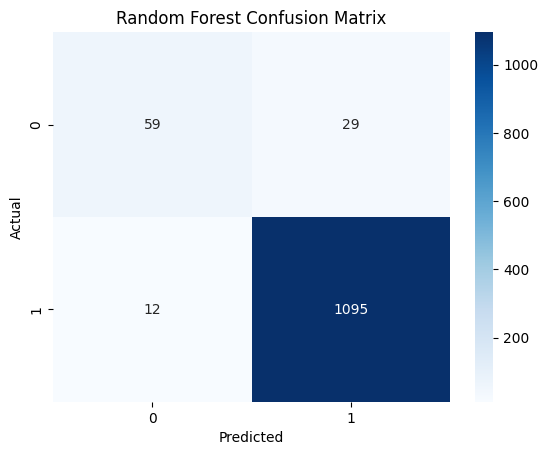

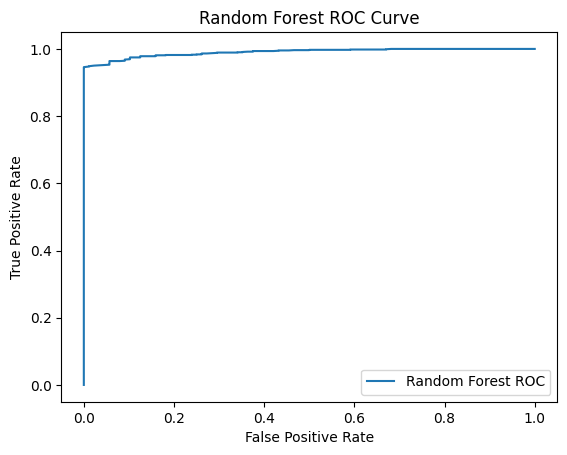

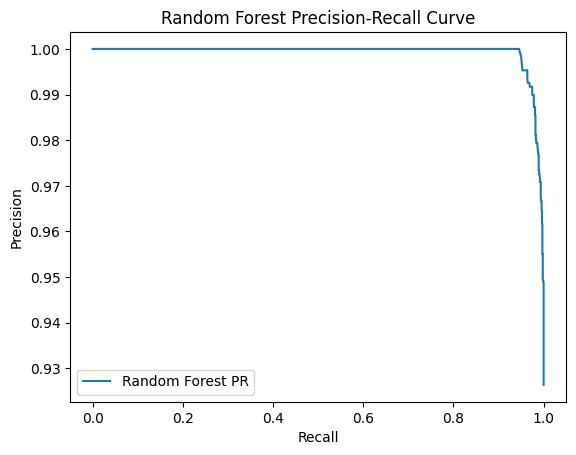

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
)


def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Core metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    rmse = np.sqrt(mean_squared_error(y_test, y_proba))

    print(f"\n🔍 {name} Evaluation Metrics:")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC AUC      : {auc:.4f}")
    print(f"RMSE         : {rmse:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall_vals, precision_vals, label=f"{name} PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} Precision-Recall Curve")
    plt.legend()
    plt.show()

evaluate_model(rf_model, "Random Forest")

In [17]:
import joblib
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']